In [72]:
from scw_compare import get_era5_lsm
from lmoments3 import distr
from percent_mean_change import transform_from_latlon
import matplotlib.pyplot as plt
import geopandas
import pandas as pd
from rasterio import features
from affine import Affine
import glob
import xarray as xr
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import genextreme
from tqdm import tqdm
import netCDF4 as nc
from ari import drop_duplicates
from scw_compare import rasterize


In [142]:
def compute_lmom_gev(da, ari):
    '''
        From an xarray dataarray with variables containing shape, location and scale parameters for a GEV, return the values for a given ari
    '''
    
    n, m = da.c_lmom.shape
    out = np.zeros((n,m))
    c = da.c_lmom.values
    loc = da["loc_lmom"].values
    scale = da.scale_lmom.values
    p = 1 - (1 / ari)
    for i in tqdm(np.arange(n)):
        for j in (np.arange(m)):
                   out[i,j] = genextreme.isf(q=1-p, c=c[i,j], loc=loc[i,j], scale=scale[i,j])
                   
    return out

def compute_gev(da, ari):
    '''
        From an xarray dataarray with variables containing shape, location and scale parameters for a GEV, return the values for a given ari
    '''
    
    n, m = da.c.shape
    out = np.zeros((n,m))
    c = da.c.values
    loc = da["loc"].values
    scale = da.scale.values
    p = 1 - (1 / ari)
    for i in tqdm(np.arange(n)):
        for j in (np.arange(m)):
                   out[i,j] = genextreme.isf(q=1-p, c=c[i,j], loc=loc[i,j], scale=scale[i,j])
                   
    return out

def compute_gev_nrm(da):
    '''
        From the NRM-maximum annual time series-fitted GEV, compute the ARI
    '''
    T = (np.logspace(-1,3,1000))
    out =  [ genextreme.isf(q=1-(1-(1/T)), c=da.attrs["nrm_c"][i], loc=da.attrs["nrm_loc"][i], scale=da.attrs["nrm_scale"][i]) for i in np.arange(4) ]
    return [out, T]   

def compute_lmom_gev_nrm(da):
    '''
        From the NRM-maximum annual time series-fitted GEV, compute the ARI
    '''
    T = (np.logspace(-1,3,1000))
    out =  [ genextreme.isf(q=1-(1-(1/T)), c=da.attrs["c_lmom_nrm"][i], loc=da.attrs["loc_lmom_nrm"][i], scale=da.attrs["scale_lmom_nrm"][i]) for i in np.arange(4) ]
    return [out, T]   


def plot_borders(nrm_da):
    xr.plot.contour(xr.where(nrm_da["aus"]==1, 1, 0), levels=[0.5,1.5], colors="k", add_labels=False)
    [xr.plot.contour(xr.where((nrm_da==i) & (~(nrm_da["aus"].isnull())), 1, 0), levels=[0.5,1.5], colors="k", add_labels=False) for i in [0,1,2,3]]

def bootstrap(u):
    fits = [distr.gev.lmom_fit(np.random.choice(u, replace=True, size=len(u))) for i in np.arange(1000)]
    p = np.linspace(0,1,10000)
    T = 1/(1-p)
    x = [np.squeeze(genextreme.isf(q=1-p, c=f["c"], loc=f["loc"], scale=f["scale"])) for f in fits]
    low_x=[]; up_x=[]
    T_boot_inds = np.arange(0, len(T), 10)
    for t in T_boot_inds:
        low, up = np.percentile([x[i][t] for i in np.arange(len(x))], [5,95])
        low_x.append(low)
        up_x.append(up)
    T_boot = T[T_boot_inds]
    return [T_boot, low_x, up_x]

In [74]:
#DJF

gev_2004 = xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_access_gev_1990_2018.nc")
#cdf_2004 = xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_access_cdf_djf_1990_2018_annmax.nc")
#cdf_nrm_2004 = [ pd.read_csv("/g/data/eg3/ab4502/gev/barpa_access_cdf_djf_1990_2018_nrm"+str(i)+"_annmax.csv") for i in np.arange(4) ]
#max_2004 = xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_access_cdf_djf_1990_2018.nc")

gev_2050 = xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_access_gev_2036_2064.nc")
#cdf_2050 = xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_access_cdf_djf_2036_2064_annmax.nc")
#cdf_nrm_2050 = [ pd.read_csv("/g/data/eg3/ab4502/gev/barpa_access_cdf_djf_2036_2064_nrm"+str(i)+"_annmax.csv") for i in np.arange(4) ]
#max_2050 = xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_access_cdf_djf_2036_2064.nc")

gev_2086 = xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_access_gev_2071_2099.nc")

#gev_ari_2004 = compute_gev(gev_2004, 10)
lmom_ari_2004 = compute_lmom_gev(gev_2004, 10)
#gev_ari_nrm_2004, T = compute_gev_nrm(gev_2004)
#lmom_ari_nrm_2004, T = compute_lmom_gev_nrm(gev_2004)

#gev_ari_2050 = compute_gev(gev_2050, 10)
lmom_ari_2050 = compute_lmom_gev(gev_2050, 10)
#gev_ari_nrm_2050, T = compute_gev_nrm(gev_2050)
#lmom_ari_nrm_2050, T = compute_lmom_gev_nrm(gev_2050)

lmom_ari_2086 = compute_lmom_gev(gev_2086, 10)

topog = xr.open_dataset("/g/data/du7/barpa/trials/BARPA-EASTAUS_12km/static/topog-BARPA-EASTAUS_12km.nc")["topog"].interp({"latitude":gev_2004.lat, "longitude":gev_2004.lon}, "nearest")
lsm_barp = ((topog.values) > 0) * 1

100%|██████████| 314/314 [00:14<00:00, 21.28it/s]


In [75]:
temp = xr.open_dataset("/g/data/eg3/ab4502/ExtremeWind/aus/regrid_1.5/ERA5__mean_lr36_historical_1979_2005.nc")
f = geopandas.read_file("/home/548/ab4502/NRM_super_clusters/NRM_super_clusters.shp")
f2 = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
shapes = [(shape, n) for n, shape in enumerate(f.geometry)]
nrm_da = rasterize(shapes, {"lon":temp.lon,"lat":temp.lat})
nrm_da["aus"] = rasterize([f2.loc[f2.name=="Australia"].geometry.values[0]], {"lon":temp.lon,"lat":temp.lat})

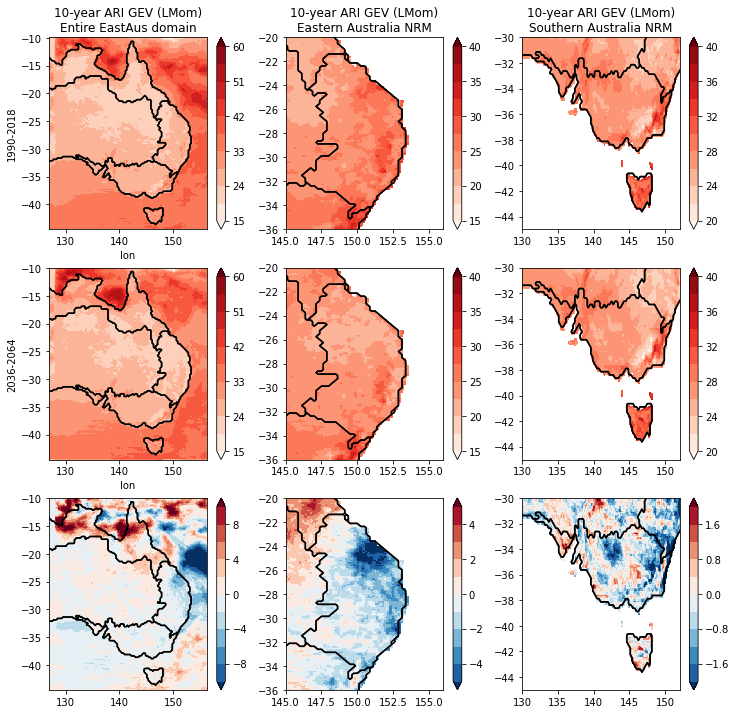

In [175]:
barra_range = [15,60]; cmap = plt.get_cmap("Reds"); levels = 11

fig=plt.figure(figsize=([12,12]))

plt.subplot(3,3,1)
xr.DataArray(data=lmom_ari_2004, coords=(gev_2004.lat, gev_2004.lon)).plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both")
plot_borders(nrm_da);plt.gca().set_ylabel(""); plt.gca().set_ylabel("1990-2018")
plt.title("10-year ARI GEV (LMom)\nEntire EastAus domain")

plt.subplot(3,3,4)
xr.DataArray(data=lmom_ari_2050, coords=(gev_2004.lat, gev_2004.lon)).plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both")
plot_borders(nrm_da);plt.gca().set_ylabel(""); plt.gca().set_ylabel("2036-2064")

plt.subplot(3,3,7)
xr.DataArray(data=(lmom_ari_2050 - lmom_ari_2004), coords=(gev_2004.lat, gev_2004.lon)).plot(vmin=None, vmax=None, levels=levels, extend="both", robust=True)
plot_borders(nrm_da);plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

plt.subplot(3,3,2)
xr.DataArray(data=xr.where(lsm_barp==1, lmom_ari_2004, np.nan), coords=(gev_2004.lat, gev_2004.lon)).\
    plot(vmin=15, vmax=40, levels=levels, cmap=cmap, extend="both",\
        xlim=[145, 156], ylim=[-36,-20])
plot_borders(nrm_da);plt.gca().set_ylabel(""); plt.gca().set_xlabel("")
plt.title("10-year ARI GEV (LMom)\nEastern Australia NRM")

plt.subplot(3,3,5)
xr.DataArray(data=xr.where(lsm_barp==1, lmom_ari_2050, np.nan), coords=(gev_2004.lat, gev_2004.lon)).\
    plot(vmin=15, vmax=40, levels=levels, cmap=cmap, extend="both",\
        xlim=[145, 156], ylim=[-36,-20])
plot_borders(nrm_da);plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

plt.subplot(3,3,8)
xr.DataArray(data=xr.where(lsm_barp==1, lmom_ari_2050-lmom_ari_2004, np.nan), coords=(gev_2004.lat, gev_2004.lon)).\
    plot(vmin=-5, vmax=5, levels=levels, extend="both",\
        xlim=[145, 156], ylim=[-36,-20], cmap=plt.get_cmap("RdBu_r"))
plot_borders(nrm_da);plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

plt.subplot(3,3,3)
xr.DataArray(data=xr.where(lsm_barp==1, lmom_ari_2004, np.nan), coords=(gev_2004.lat, gev_2004.lon)).\
    plot(vmin=20, vmax=40, levels=levels, cmap=cmap, extend="both",\
        xlim=[130, 152], ylim=[-45,-30])
plot_borders(nrm_da);plt.gca().set_ylabel(""); plt.gca().set_xlabel("")
plt.title("10-year ARI GEV (LMom)\nSouthern Australia NRM")

plt.subplot(3,3,6)
xr.DataArray(data=xr.where(lsm_barp==1, lmom_ari_2050, np.nan), coords=(gev_2004.lat, gev_2004.lon)).\
    plot(vmin=20, vmax=40, levels=levels, cmap=cmap, extend="both",\
        xlim=[130, 152], ylim=[-45,-30])
plot_borders(nrm_da);plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

plt.subplot(3,3,9)
xr.DataArray(data=xr.where(lsm_barp==1, lmom_ari_2050-lmom_ari_2004, np.nan), coords=(gev_2004.lat, gev_2004.lon)).\
    plot(vmin=-2, vmax=2, levels=levels, extend="both",\
        xlim=[130, 152], ylim=[-45,-30], cmap=plt.get_cmap("RdBu_r"))
plot_borders(nrm_da);plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

plt.savefig("/g/data/eg3/ab4502/figs/barpa/ari_mid.png", bbox_inches="tight")

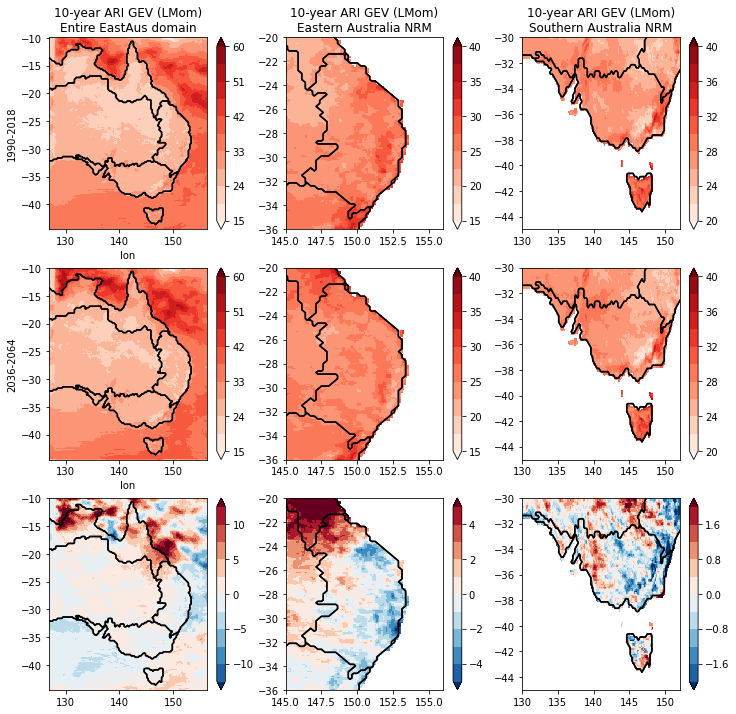

In [177]:
barra_range = [15,60]; cmap = plt.get_cmap("Reds"); levels = 11

fig=plt.figure(figsize=([12,12]))

plt.subplot(3,3,1)
xr.DataArray(data=lmom_ari_2004, coords=(gev_2004.lat, gev_2004.lon)).plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both")
plot_borders(nrm_da);plt.gca().set_ylabel(""); plt.gca().set_ylabel("1990-2018")
plt.title("10-year ARI GEV (LMom)\nEntire EastAus domain")

plt.subplot(3,3,4)
xr.DataArray(data=lmom_ari_2086, coords=(gev_2004.lat, gev_2004.lon)).plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both")
plot_borders(nrm_da);plt.gca().set_ylabel(""); plt.gca().set_ylabel("2036-2064")

plt.subplot(3,3,7)
xr.DataArray(data=(lmom_ari_2086 - lmom_ari_2004), coords=(gev_2004.lat, gev_2004.lon)).plot(vmin=None, vmax=None, levels=levels, extend="both", robust=True)
plot_borders(nrm_da);plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

plt.subplot(3,3,2)
xr.DataArray(data=xr.where(lsm_barp==1, lmom_ari_2004, np.nan), coords=(gev_2004.lat, gev_2004.lon)).\
    plot(vmin=15, vmax=40, levels=levels, cmap=cmap, extend="both",\
        xlim=[145, 156], ylim=[-36,-20])
plot_borders(nrm_da);plt.gca().set_ylabel(""); plt.gca().set_xlabel("")
plt.title("10-year ARI GEV (LMom)\nEastern Australia NRM")

plt.subplot(3,3,5)
xr.DataArray(data=xr.where(lsm_barp==1, lmom_ari_2086, np.nan), coords=(gev_2004.lat, gev_2004.lon)).\
    plot(vmin=15, vmax=40, levels=levels, cmap=cmap, extend="both",\
        xlim=[145, 156], ylim=[-36,-20])
plot_borders(nrm_da);plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

plt.subplot(3,3,8)
xr.DataArray(data=xr.where(lsm_barp==1, lmom_ari_2086-lmom_ari_2004, np.nan), coords=(gev_2004.lat, gev_2004.lon)).\
    plot(vmin=-5, vmax=5, levels=levels, extend="both",\
        xlim=[145, 156], ylim=[-36,-20], cmap=plt.get_cmap("RdBu_r"))
plot_borders(nrm_da);plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

plt.subplot(3,3,3)
xr.DataArray(data=xr.where(lsm_barp==1, lmom_ari_2004, np.nan), coords=(gev_2004.lat, gev_2004.lon)).\
    plot(vmin=20, vmax=40, levels=levels, cmap=cmap, extend="both",\
        xlim=[130, 152], ylim=[-45,-30])
plot_borders(nrm_da);plt.gca().set_ylabel(""); plt.gca().set_xlabel("")
plt.title("10-year ARI GEV (LMom)\nSouthern Australia NRM")

plt.subplot(3,3,6)
xr.DataArray(data=xr.where(lsm_barp==1, lmom_ari_2086, np.nan), coords=(gev_2004.lat, gev_2004.lon)).\
    plot(vmin=20, vmax=40, levels=levels, cmap=cmap, extend="both",\
        xlim=[130, 152], ylim=[-45,-30])
plot_borders(nrm_da);plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

plt.subplot(3,3,9)
xr.DataArray(data=xr.where(lsm_barp==1, lmom_ari_2086-lmom_ari_2004, np.nan), coords=(gev_2004.lat, gev_2004.lon)).\
    plot(vmin=-2, vmax=2, levels=levels, extend="both",\
        xlim=[130, 152], ylim=[-45,-30], cmap=plt.get_cmap("RdBu_r"))
plot_borders(nrm_da);plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

plt.savefig("/g/data/eg3/ab4502/figs/barpa/ari_late.png", bbox_inches="tight")

In [78]:
#Load AWS station information and data, plot stations

names = ["id", "stn_no", "district", "stn_name", "1", "2", "lat", "lon", "3", "4", "5", "6", "7", "8", \
"9", "10", "11", "12", "13", "14", "15", "16"]	
df = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/obs/aws/daily_aus_full/DC02D_StnDet_999999999643799.txt",\
names=names, header=0)
renames = {'ALICE SPRINGS AIRPORT                   ':"Alice Springs",\
'GILES METEOROLOGICAL OFFICE             ':"Giles",\
'COBAR MO                                ':"Cobar",\
'AMBERLEY AMO                            ':"Amberley",\
'SYDNEY AIRPORT AMO                      ':"Sydney",\
'MELBOURNE AIRPORT                       ':"Melbourne",\
'MACKAY M.O                              ':"Mackay",\
'WEIPA AERO                              ':"Weipa",\
'MOUNT ISA AERO                          ':"Mount Isa",\
'ESPERANCE                               ':"Esperance",\
'ADELAIDE AIRPORT                        ':"Adelaide",\
'CHARLEVILLE AERO                        ':"Charleville",\
'CEDUNA AMO                              ':"Ceduna",\
'OAKEY AERO                              ':"Oakey",\
'WOOMERA AERODROME                       ':"Woomera",\
'TENNANT CREEK AIRPORT                   ':"Tennant Creek",\
'GOVE AIRPORT                            ':"Gove",\
'COFFS HARBOUR MO                        ':"Coffs Harbour",\
'MEEKATHARRA AIRPORT                     ':"Meekatharra",\
'HALLS CREEK METEOROLOGICAL OFFICE       ':"Halls Creek",\
'ROCKHAMPTON AERO                        ':"Rockhampton",\
'MOUNT GAMBIER AERO                      ':"Mount Gambier",\
'PERTH AIRPORT                           ':"Perth",\
'WILLIAMTOWN RAAF                        ':"Williamtown",\
'CARNARVON AIRPORT                       ':"Carnarvon",\
'KALGOORLIE-BOULDER AIRPORT              ':"Kalgoorlie",\
'DARWIN AIRPORT                          ':"Darwin",\
'CAIRNS AERO                             ':"Cairns",\
'MILDURA AIRPORT                         ':"Mildura",\
'WAGGA WAGGA AMO                         ':"Wagga Wagga",\
'BROOME AIRPORT                          ':"Broome",\
'EAST SALE                               ':"East Sale",\
'TOWNSVILLE AERO                         ':"Townsville",\
'HOBART (ELLERSLIE ROAD)                 ':"Hobart",\
'PORT HEDLAND AIRPORT                    ':"Port Hedland"}
df = df.replace({"stn_name":renames})
points = [(df.lon.iloc[i], df.lat.iloc[i]) for i in np.arange(df.shape[0])]
temp = xr.open_dataset("/g/data/eg3/ab4502/ExtremeWind/aus/regrid_1.5/ERA5__mean_lr36_historical_1979_2005.nc")
f = geopandas.read_file("/home/548/ab4502/NRM_super_clusters/NRM_super_clusters.shp")
f2 = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
shapes = [(shape, n) for n, shape in enumerate(f.geometry)]
nrm_da = rasterize(shapes, {"lon":temp.lon,"lat":temp.lat})
nrm_da["aus"] = rasterize([f2.loc[f2.name=="Australia"].geometry.values[0]], {"lon":temp.lon,"lat":temp.lat})
names = ["record_id","stn_no","stn_name","locality", "state","lat","lon","height","date_str",\
                "wind_gust","quality","wind_dir", "wind_dir_quality", "max_gust_str_lt", \
                "max_gust_time_quality", "eof"]
data_types = dict(record_id=str, stn_no=int, stn_name=str, locality=str, state=str, lat=float, lon=float,\
                                height=str, date_str=str, wind_gust=float, quality=str, \
                                wind_dir=str, wind_dir_quality=str, max_gust_str_lt=str,\
                                max_gust_time_quality=str,\
                                eof=str)
f = "/g/data/eg3/ab4502/ExtremeWind/obs/aws/daily_aus_full/DC02D_Data_999999999720188.txt"
obs = pd.read_csv(f, names=names, dtype=data_types, na_values={"wind_gust":'     ', "max_gust_str_lt":"    "})
obs = obs.replace({"stn_name":renames})
obs["wind_dir"] = obs["wind_dir"].str.strip()
obs["wind_dir"] = pd.to_numeric(obs.wind_dir, errors="coerce")
obs["stn_name"] = obs["stn_name"].str.strip()
obs["year"] = obs.date_str.str.slice(6,10).astype("int")
obs["month"] = obs.date_str.str.slice(3,5).astype("int")
obs["day_lt"] = obs.date_str.str.slice(0,2).astype("int")
obs["daily_date_lt"] = pd.to_datetime({"year":obs["year"],"month":obs["month"],"day":obs["day_lt"]})

/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7

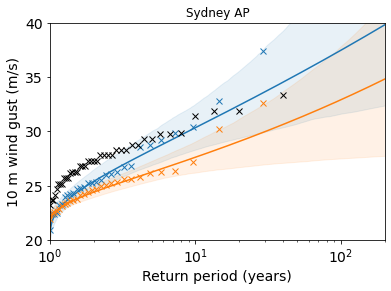

In [180]:
#Plot ARI comparison between BARRA, BARPA and station data

stn_lon = df[df.stn_name=="Sydney"]["lon"]
stn_lat = df[df.stn_name=="Sydney"]["lat"]

#BARRA-SY
a,b = np.meshgrid(gev_2004.lon, gev_2004.lat)
a[lsm_barp==0] = np.nan
b[lsm_barp==0] = np.nan
dist = np.sqrt(np.square(a-stn_lon.values[0]) + \
                        np.square(b-stn_lat.values[0]))
temp_lat,temp_lon = np.unravel_index(np.nanargmin(dist),dist.shape)

c = gev_2004["c"].isel({"lat":temp_lat, "lon":temp_lon})
loc = gev_2004["loc"].isel({"lat":temp_lat, "lon":temp_lon})
scale = gev_2004["scale"].isel({"lat":temp_lat, "lon":temp_lon})
p = np.linspace(0,1,10000)
T = 1/(1-p)
x = np.squeeze(genextreme.isf(q=1-p, c=c, loc=loc, scale=scale))
x_raw = np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_ACCESS1-0_annmax_annual_1990_2018.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values)
T_raw = (1 / (1 - ECDF(x_raw).y))
T_boot, low_x1, up_x1 = bootstrap(np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_ACCESS1-0_annmax_annual_1990_2018.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values))

c = gev_2050["c"].isel({"lat":temp_lat, "lon":temp_lon})
loc = gev_2050["loc"].isel({"lat":temp_lat, "lon":temp_lon})
scale = gev_2050["scale"].isel({"lat":temp_lat, "lon":temp_lon})
x2 = np.squeeze(genextreme.isf(q=1-p, c=c, loc=loc, scale=scale))
x2_raw = np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_ACCESS1-0_annmax_annual_2036_2064.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values)
T2_raw = (1 / (1 - ECDF(x2_raw).y))
T_boot, low_x2, up_x2 = bootstrap(np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_ACCESS1-0_annmax_annual_2036_2064.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values))

x_obs = np.sort(obs[obs.stn_name=="Sydney"][["daily_date_lt", "wind_gust"]].iloc[:-1].resample("1Y", on="daily_date_lt").max()["wind_gust"].values)
T_obs = (1 / (1 - ECDF(x_obs).y))

plt.plot(T, x, color="tab:blue")
plt.plot(T_raw[:-1], x_raw, color="tab:blue", ls="none", marker="x")
plt.fill_between(T_boot, low_x1, up_x1, alpha=0.1, color="tab:blue")

plt.plot(T, x2, color="tab:orange")
plt.plot(T2_raw[:-1], x2_raw, color="tab:orange", ls="none", marker="x")
plt.fill_between(T_boot, low_x2, up_x2, alpha=0.1, color="tab:orange")

plt.plot(T_obs[:-1], x_obs, marker="x", color="k", linestyle="none", label="AWS")

plt.ylim([20,40])
plt.xlim([1,200])
plt.xscale("log")
plt.title("Sydney AP")
ax=plt.gca()
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel("Return period (years)", size=14)
plt.ylabel("10 m wind gust (m/s)", size=14)

plt.savefig("/g/data/eg3/ab4502/figs/barpa/ari_syd.png", bbox_inches="tight")

/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7

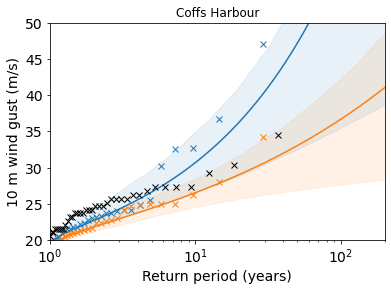

In [178]:
#Plot ARI comparison between BARRA, BARPA and station data

stn_lon = df[df.stn_name=="Coffs Harbour"]["lon"]
stn_lat = df[df.stn_name=="Coffs Harbour"]["lat"]

#BARRA-SY
a,b = np.meshgrid(gev_2004.lon, gev_2004.lat)
a[lsm_barp==0] = np.nan
b[lsm_barp==0] = np.nan
dist = np.sqrt(np.square(a-stn_lon.values[0]) + \
                        np.square(b-stn_lat.values[0]))
temp_lat,temp_lon = np.unravel_index(np.nanargmin(dist),dist.shape)

c = gev_2004["c"].isel({"lat":temp_lat, "lon":temp_lon})
loc = gev_2004["loc"].isel({"lat":temp_lat, "lon":temp_lon})
scale = gev_2004["scale"].isel({"lat":temp_lat, "lon":temp_lon})
p = np.linspace(0,1,10000)
T = 1/(1-p)
x = np.squeeze(genextreme.isf(q=1-p, c=c, loc=loc, scale=scale))
x_raw = np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_ACCESS1-0_annmax_annual_1990_2018.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values)
T_raw = (1 / (1 - ECDF(x_raw).y))
T_boot, low_x1, up_x1 = bootstrap(np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_ACCESS1-0_annmax_annual_1990_2018.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values))

c = gev_2050["c"].isel({"lat":temp_lat, "lon":temp_lon})
loc = gev_2050["loc"].isel({"lat":temp_lat, "lon":temp_lon})
scale = gev_2050["scale"].isel({"lat":temp_lat, "lon":temp_lon})
x2 = np.squeeze(genextreme.isf(q=1-p, c=c, loc=loc, scale=scale))
x2_raw = np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_ACCESS1-0_annmax_annual_2036_2064.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values)
T2_raw = (1 / (1 - ECDF(x2_raw).y))
T_boot, low_x2, up_x2 = bootstrap(np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_ACCESS1-0_annmax_annual_2036_2064.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values))

x_obs = np.sort(obs[obs.stn_name=="Coffs Harbour"][["daily_date_lt", "wind_gust"]].iloc[:-1].resample("1Y", on="daily_date_lt").max()["wind_gust"].values)
T_obs = (1 / (1 - ECDF(x_obs).y))

plt.plot(T, x, color="tab:blue")
plt.plot(T_raw[:-1], x_raw, color="tab:blue", ls="none", marker="x")
plt.fill_between(T_boot, low_x1, up_x1, alpha=0.1, color="tab:blue")

plt.plot(T, x2, color="tab:orange")
plt.plot(T2_raw[:-1], x2_raw, color="tab:orange", ls="none", marker="x")
plt.fill_between(T_boot, low_x2, up_x2, alpha=0.1, color="tab:orange")

plt.plot(T_obs[:-1], x_obs, marker="x", color="k", linestyle="none", label="AWS")

plt.ylim([20,50])
plt.xlim([1,200])
plt.xscale("log")
plt.title("Coffs Harbour")
ax=plt.gca()
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel("Return period (years)", size=14)
plt.ylabel("10 m wind gust (m/s)", size=14)

plt.savefig("/g/data/eg3/ab4502/figs/barpa/ari_cof.png", bbox_inches="tight")

/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7

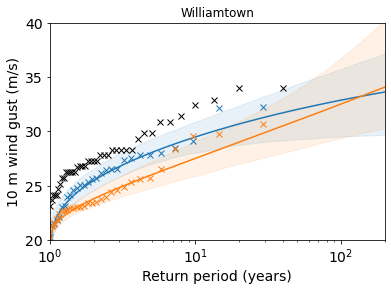

In [179]:
#Plot ARI comparison between BARRA, BARPA and station data

stn_lon = df[df.stn_name=="Williamtown"]["lon"]
stn_lat = df[df.stn_name=="Williamtown"]["lat"]

#BARRA-SY
a,b = np.meshgrid(gev_2004.lon, gev_2004.lat)
a[lsm_barp==0] = np.nan
b[lsm_barp==0] = np.nan
dist = np.sqrt(np.square(a-stn_lon.values[0]) + \
                        np.square(b-stn_lat.values[0]))
temp_lat,temp_lon = np.unravel_index(np.nanargmin(dist),dist.shape)

c = gev_2004["c"].isel({"lat":temp_lat, "lon":temp_lon})
loc = gev_2004["loc"].isel({"lat":temp_lat, "lon":temp_lon})
scale = gev_2004["scale"].isel({"lat":temp_lat, "lon":temp_lon})
p = np.linspace(0,1,10000)
T = 1/(1-p)
x = np.squeeze(genextreme.isf(q=1-p, c=c, loc=loc, scale=scale))
x_raw = np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_ACCESS1-0_annmax_annual_1990_2018.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values)
T_raw = (1 / (1 - ECDF(x_raw).y))
T_boot, low_x1, up_x1 = bootstrap(np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_ACCESS1-0_annmax_annual_1990_2018.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values))

c = gev_2050["c"].isel({"lat":temp_lat, "lon":temp_lon})
loc = gev_2050["loc"].isel({"lat":temp_lat, "lon":temp_lon})
scale = gev_2050["scale"].isel({"lat":temp_lat, "lon":temp_lon})
x2 = np.squeeze(genextreme.isf(q=1-p, c=c, loc=loc, scale=scale))
x2_raw = np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_ACCESS1-0_annmax_annual_2036_2064.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values)
T2_raw = (1 / (1 - ECDF(x2_raw).y))
T_boot, low_x2, up_x2 = bootstrap(np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_ACCESS1-0_annmax_annual_2036_2064.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values))

x_obs = np.sort(obs[obs.stn_name=="Williamtown"][["daily_date_lt", "wind_gust"]].iloc[:-1].resample("1Y", on="daily_date_lt").max()["wind_gust"].values)
T_obs = (1 / (1 - ECDF(x_obs).y))

plt.plot(T, x, color="tab:blue")
plt.plot(T_raw[:-1], x_raw, color="tab:blue", ls="none", marker="x")
plt.fill_between(T_boot, low_x1, up_x1, alpha=0.1, color="tab:blue")

plt.plot(T, x2, color="tab:orange")
plt.plot(T2_raw[:-1], x2_raw, color="tab:orange", ls="none", marker="x")
plt.fill_between(T_boot, low_x2, up_x2, alpha=0.1, color="tab:orange")

plt.plot(T_obs[:-1], x_obs, marker="x", color="k", linestyle="none", label="AWS")

plt.ylim([20,40])
plt.xlim([1,200])
plt.xscale("log")
plt.title("Williamtown")
ax=plt.gca()
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel("Return period (years)", size=14)
plt.ylabel("10 m wind gust (m/s)", size=14)

plt.savefig("/g/data/eg3/ab4502/figs/barpa/ari_wil.png", bbox_inches="tight")

/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide


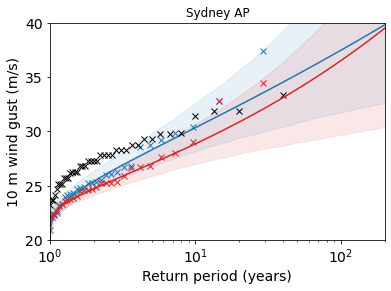

In [188]:
#Plot ARI comparison between BARRA, BARPA and station data

stn_lon = df[df.stn_name=="Sydney"]["lon"]
stn_lat = df[df.stn_name=="Sydney"]["lat"]

#BARRA-SY
a,b = np.meshgrid(gev_2004.lon, gev_2004.lat)
a[lsm_barp==0] = np.nan
b[lsm_barp==0] = np.nan
dist = np.sqrt(np.square(a-stn_lon.values[0]) + \
                        np.square(b-stn_lat.values[0]))
temp_lat,temp_lon = np.unravel_index(np.nanargmin(dist),dist.shape)

c = gev_2004["c"].isel({"lat":temp_lat, "lon":temp_lon})
loc = gev_2004["loc"].isel({"lat":temp_lat, "lon":temp_lon})
scale = gev_2004["scale"].isel({"lat":temp_lat, "lon":temp_lon})
p = np.linspace(0,1,10000)
T = 1/(1-p)
x = np.squeeze(genextreme.isf(q=1-p, c=c, loc=loc, scale=scale))
x_raw = np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_ACCESS1-0_annmax_annual_1990_2018.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values)
T_raw = (1 / (1 - ECDF(x_raw).y))
T_boot, low_x1, up_x1 = bootstrap(np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_ACCESS1-0_annmax_annual_1990_2018.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values))

c = gev_2086["c"].isel({"lat":temp_lat, "lon":temp_lon})
loc = gev_2086["loc"].isel({"lat":temp_lat, "lon":temp_lon})
scale = gev_2086["scale"].isel({"lat":temp_lat, "lon":temp_lon})
x3 = np.squeeze(genextreme.isf(q=1-p, c=c, loc=loc, scale=scale))
x3_raw = np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_ACCESS1-0_annmax_annual_2071_2099.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values)
T3_raw = (1 / (1 - ECDF(x3_raw).y))
T_boot, low_x3, up_x3 = bootstrap(np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_ACCESS1-0_annmax_annual_2071_2099.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values))

x_obs = np.sort(obs[obs.stn_name=="Sydney"][["daily_date_lt", "wind_gust"]].iloc[:-1].resample("1Y", on="daily_date_lt").max()["wind_gust"].values)
T_obs = (1 / (1 - ECDF(x_obs).y))

plt.plot(T, x, color="tab:blue")
plt.plot(T_raw[:-1], x_raw, color="tab:blue", ls="none", marker="x")
plt.fill_between(T_boot, low_x1, up_x1, alpha=0.1, color="tab:blue")

plt.plot(T_obs[:-1], x_obs, marker="x", color="k", linestyle="none", label="AWS")

plt.plot(T, x3, color="tab:red")
plt.plot(T3_raw[:-1], x3_raw, color="tab:red", ls="none", marker="x")
plt.fill_between(T_boot, low_x3, up_x3, alpha=0.1, color="tab:red")

plt.ylim([20,40])
plt.xlim([1,200])
plt.xscale("log")
plt.title("Sydney AP")
ax=plt.gca()
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel("Return period (years)", size=14)
plt.ylabel("10 m wind gust (m/s)", size=14)

plt.savefig("/g/data/eg3/ab4502/figs/barpa/ari_syd_late.png", bbox_inches="tight")

/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide


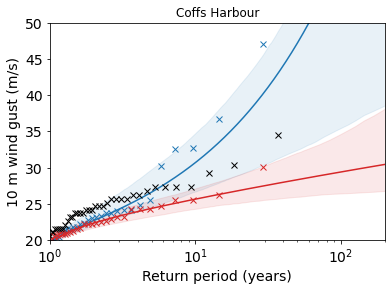

In [189]:
#Plot ARI comparison between BARRA, BARPA and station data

stn_lon = df[df.stn_name=="Coffs Harbour"]["lon"]
stn_lat = df[df.stn_name=="Coffs Harbour"]["lat"]

#BARRA-SY
a,b = np.meshgrid(gev_2004.lon, gev_2004.lat)
a[lsm_barp==0] = np.nan
b[lsm_barp==0] = np.nan
dist = np.sqrt(np.square(a-stn_lon.values[0]) + \
                        np.square(b-stn_lat.values[0]))
temp_lat,temp_lon = np.unravel_index(np.nanargmin(dist),dist.shape)

c = gev_2004["c"].isel({"lat":temp_lat, "lon":temp_lon})
loc = gev_2004["loc"].isel({"lat":temp_lat, "lon":temp_lon})
scale = gev_2004["scale"].isel({"lat":temp_lat, "lon":temp_lon})
p = np.linspace(0,1,10000)
T = 1/(1-p)
x = np.squeeze(genextreme.isf(q=1-p, c=c, loc=loc, scale=scale))
x_raw = np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_ACCESS1-0_annmax_annual_1990_2018.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values)
T_raw = (1 / (1 - ECDF(x_raw).y))
T_boot, low_x1, up_x1 = bootstrap(np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_ACCESS1-0_annmax_annual_1990_2018.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values))

c = gev_2086["c"].isel({"lat":temp_lat, "lon":temp_lon})
loc = gev_2086["loc"].isel({"lat":temp_lat, "lon":temp_lon})
scale = gev_2086["scale"].isel({"lat":temp_lat, "lon":temp_lon})
x3 = np.squeeze(genextreme.isf(q=1-p, c=c, loc=loc, scale=scale))
x3_raw = np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_ACCESS1-0_annmax_annual_2071_2099.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values)
T3_raw = (1 / (1 - ECDF(x3_raw).y))
T_boot, low_x3, up_x3 = bootstrap(np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_ACCESS1-0_annmax_annual_2071_2099.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values))

x_obs = np.sort(obs[obs.stn_name=="Coffs Harbour"][["daily_date_lt", "wind_gust"]].iloc[:-1].resample("1Y", on="daily_date_lt").max()["wind_gust"].values)
T_obs = (1 / (1 - ECDF(x_obs).y))

plt.plot(T, x, color="tab:blue")
plt.plot(T_raw[:-1], x_raw, color="tab:blue", ls="none", marker="x")
plt.fill_between(T_boot, low_x1, up_x1, alpha=0.1, color="tab:blue")

plt.plot(T_obs[:-1], x_obs, marker="x", color="k", linestyle="none", label="AWS")
plt.fill_between(T_boot, low_x3, up_x3, alpha=0.1, color="tab:red")
plt.plot(T, x3, color="tab:red")
plt.plot(T3_raw[:-1], x3_raw, color="tab:red", ls="none", marker="x")
plt.ylim([20,50])
plt.xlim([1,200])
plt.xscale("log")
plt.title("Coffs Harbour")
ax=plt.gca()
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel("Return period (years)", size=14)
plt.ylabel("10 m wind gust (m/s)", size=14)

plt.savefig("/g/data/eg3/ab4502/figs/barpa/ari_cof_late.png", bbox_inches="tight")

/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide
/g/data/eg3/ab4502/miniconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide


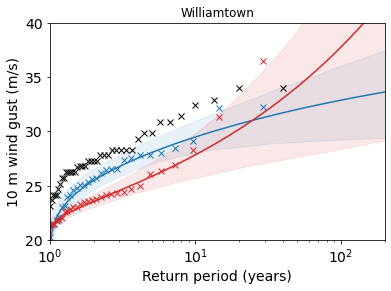

In [192]:
#Plot ARI comparison between BARRA, BARPA and station data

stn_lon = df[df.stn_name=="Williamtown"]["lon"]
stn_lat = df[df.stn_name=="Williamtown"]["lat"]

#BARRA-SY
a,b = np.meshgrid(gev_2004.lon, gev_2004.lat)
a[lsm_barp==0] = np.nan
b[lsm_barp==0] = np.nan
dist = np.sqrt(np.square(a-stn_lon.values[0]) + \
                        np.square(b-stn_lat.values[0]))
temp_lat,temp_lon = np.unravel_index(np.nanargmin(dist),dist.shape)

c = gev_2004["c"].isel({"lat":temp_lat, "lon":temp_lon})
loc = gev_2004["loc"].isel({"lat":temp_lat, "lon":temp_lon})
scale = gev_2004["scale"].isel({"lat":temp_lat, "lon":temp_lon})
p = np.linspace(0,1,10000)
T = 1/(1-p)
x = np.squeeze(genextreme.isf(q=1-p, c=c, loc=loc, scale=scale))
x_raw = np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_ACCESS1-0_annmax_annual_1990_2018.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values)
T_raw = (1 / (1 - ECDF(x_raw).y))
T_boot, low_x1, up_x1 = bootstrap(np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_ACCESS1-0_annmax_annual_1990_2018.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values))

c = gev_2086["c"].isel({"lat":temp_lat, "lon":temp_lon})
loc = gev_2086["loc"].isel({"lat":temp_lat, "lon":temp_lon})
scale = gev_2086["scale"].isel({"lat":temp_lat, "lon":temp_lon})
x3 = np.squeeze(genextreme.isf(q=1-p, c=c, loc=loc, scale=scale))
x3_raw = np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_ACCESS1-0_annmax_annual_2071_2099.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values)
T3_raw = (1 / (1 - ECDF(x3_raw).y))
T_boot, low_x3, up_x3 = bootstrap(np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_ACCESS1-0_annmax_annual_2071_2099.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values))

x_obs = np.sort(obs[obs.stn_name=="Williamtown"][["daily_date_lt", "wind_gust"]].iloc[:-1].resample("1Y", on="daily_date_lt").max()["wind_gust"].values)
T_obs = (1 / (1 - ECDF(x_obs).y))

plt.plot(T, x, color="tab:blue")
plt.plot(T_raw[:-1], x_raw, color="tab:blue", ls="none", marker="x")
plt.fill_between(T_boot, low_x1, up_x1, alpha=0.1, color="tab:blue")

plt.plot(T_obs[:-1], x_obs, marker="x", color="k", linestyle="none", label="AWS")

plt.fill_between(T_boot, low_x3, up_x3, alpha=0.1, color="tab:red")
plt.plot(T, x3, color="tab:red")
plt.plot(T3_raw[:-1], x3_raw, color="tab:red", ls="none", marker="x")

plt.ylim([20,40])
plt.xlim([1,200])
plt.xscale("log")
plt.title("Williamtown")
ax=plt.gca()
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel("Return period (years)", size=14)
plt.ylabel("10 m wind gust (m/s)", size=14)

plt.savefig("/g/data/eg3/ab4502/figs/barpa/ari_wil_late.png", bbox_inches="tight")